# **UNSUPERVISED CUSTOMER CLUSTERING**
### **NAME**: EDWARD TAN YUAN CHONG


### **IMPORT MODULES**

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
# Set style of plots on seaborn
sns.set(font='Century Gothic')
# Ignore warnings
import warnings
warnings.simplefilter('ignore')
# Color palette
muted = sns.color_palette('muted')

c:\Users\edw4r\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## <b>CONTENT
<span style='font-size:24px;'>

<b>1. INTRODUCTION

<b>2. EXPLORATORY DATA ANALYSIS [EDA]

<b>3. FEATURE ENGINEERING

<b>4. DETERMINE NUMBER OF CLUSTERS K AND HYPERPARAMETER TUNING

<b>5. ALGORITHM SELECTION

<b>6. ALGORITHM EVALUATION

<b>7. CONCLUSION

</span>

## **1. INTRODUCTION**



**DATASET**: 

Customer_Dataset.csv

**INFORMATION OF DATASET**: 

Dataset contains a mall’s information of each customer such as Gender, Age, Income and How Much They Spend (Spending Score), along with CustomerID as an identifier.

CustomerID: unique customer identifier

Gender: customer gender

Age: customer age

Income (k$): monthly income

How Much They Spend: spending score range from 0 - 100, the higher the score, the more they spend => Renamed to Spending Score

**TASK**: 

Build a clustering algorithm to cluster customers and extract pieces of information and insights to allow the mall to find out their group of most valuable customers and how to retain them.


### **IMPORT DATASET**

In [2]:
# Import customer dataset
customer = pd.read_csv("./Customer_Dataset.csv")

### **UNDERSTANDING DATASET**
This section includes some feature engineering as well.

In [3]:
customer.head(5)

,CustomerID,Gender,Age,Income (k$),How Much They Spend
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


We can see that there are columns such as CustomerID to identify each customer, Gender, Age, Income and How Much They Spend by each customer.

I dropped the CustomerID column as it is irrelevant to the algorithm and might lead to overfitting or affect the algorithm's performance.

In [4]:
# Drop "CustomerID" column
customer = customer.drop(['CustomerID'],axis=1)

We should also rename the column 'How Much They Spend' to 'Spending Score' for clarity, as it was stated in the data dictionary

In [5]:
# Rename "How Much They Spend" column
customer = customer.rename(columns={'How Much They Spend':'Spending Score'})

In [6]:
# Print shape of dataset
print("Shape of Dataset: " + str(customer.shape))

Shape of Dataset: (200, 4)


In [7]:
# .describe on dataset
customer.describe()

,Age,Income (k$),Spending Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


From .describe(), we can see that the range of values between the features do not differ much, and they have roughly the same scale, hence we would likely not require feature scaling.

In [8]:
# Check for missing values
print("Number of missing values:\n" + str(customer.isnull().sum()))

Number of missing values:
Gender            0
Age               0
Income (k$)       0
Spending Score    0
dtype: int64


In [9]:
# Check for duplicate rows
print("Number of duplicate rows: " + str(customer.duplicated().sum()))

Number of duplicate rows: 0


In [10]:
# Check datatypes
print("Datatypes of each column:\n" + str(customer.dtypes))

Datatypes of each column:
Gender            object
Age                int64
Income (k$)        int64
Spending Score     int64
dtype: object


## **2. EXPLORATORY DATA ANALYSIS [EDA]**

### **CHART 1: REGRESSION PLOT OF INCOME AND SPENDING SCORE AGAINST AGE**

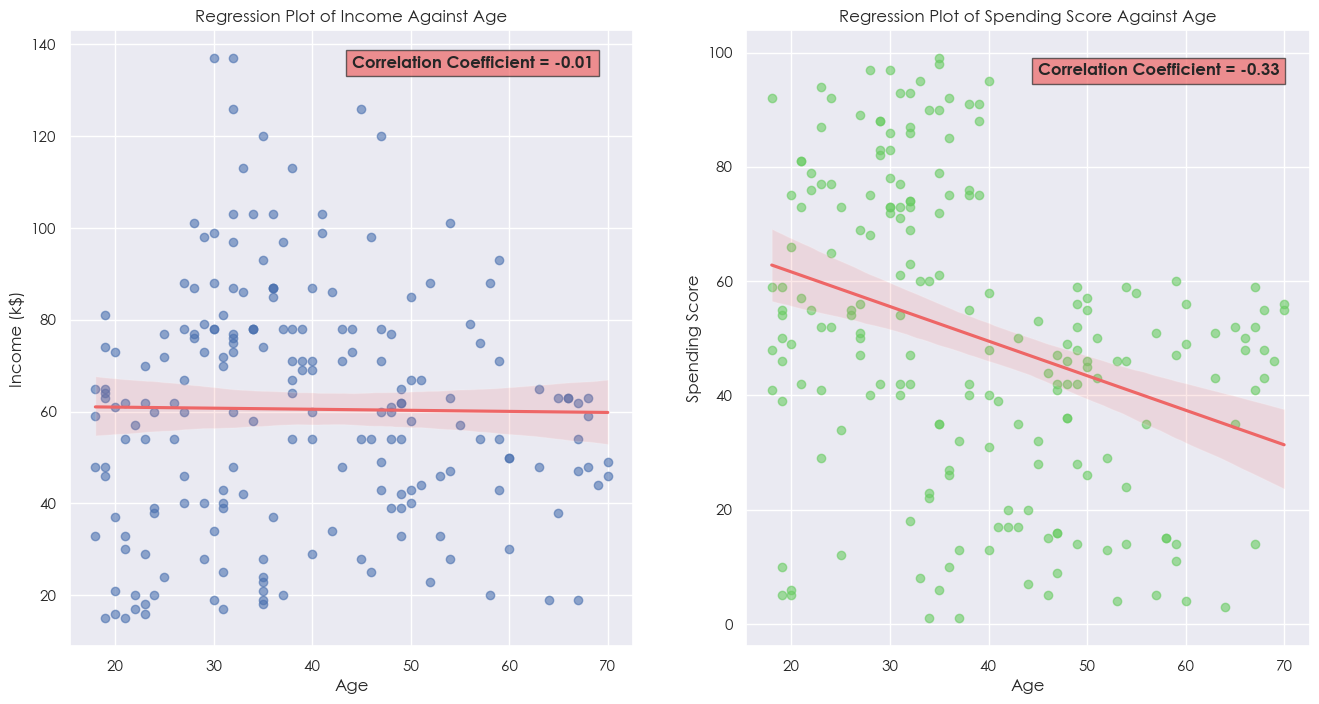

In [11]:
# Plot regression plots of income and Spending Score against age
fig,axs = plt.subplots(1,2,figsize=(16,8))
sns.regplot(x=customer['Age'],y=customer['Income (k$)'],line_kws={'color':'#ee6666'},scatter_kws={"alpha":0.6},ax=axs[0]).set(title='Regression Plot of Income Against Age')
corr = customer[['Age','Income (k$)']].corr()
axs[0].text(44,135,'Correlation Coefficient = {:.2f}'.format(corr.values[0,1]),bbox=dict(facecolor="#ee6666",alpha=0.7,edgecolor="#2a2a2a"),fontweight='bold')
sns.regplot(x=customer['Age'],y=customer['Spending Score'],color=muted[2],line_kws={'color':'#ee6666'},scatter_kws={"alpha":0.6},ax=axs[1]).set(title='Regression Plot of Spending Score Against Age')
corr1 = customer[['Age','Spending Score']].corr()
axs[1].text(45,96,'Correlation Coefficient = {:.2f}'.format(corr1.values[0,1]),bbox=dict(facecolor="#ee6666",alpha=0.7,edgecolor="#2a2a2a"),fontweight='bold')
plt.show()

**ANALYSIS OF CHART 1:** 

From the regression plot of income against age, we can see that there is almost no linear relationship between the two variables shown by the correlation coefficient of -0.01, which shows that a customer's age likely does not affect their income.

Meanwhile, from the regression plot of spending against age, we can see that there is a weak linear relationship between the two variables shown by the correlation coefficient of -0.33, which is likely due to the fact that as the customer becomes older, they might not have a fixed income due to retirement, or experience changes in lifestyle or changes in consumption habits, and possibly other reasons that may affect their spending score. Another thing to take note is that customers aged 40 and above only have spending scores below 60, showing that customers in their 20s and 30s do spend more in comparison to customers aged 40 and above. This shows that a customer's age does affect their spending score in the mall.

### **CHART 2: COUNT OF CUSTOMERS BY AGE**

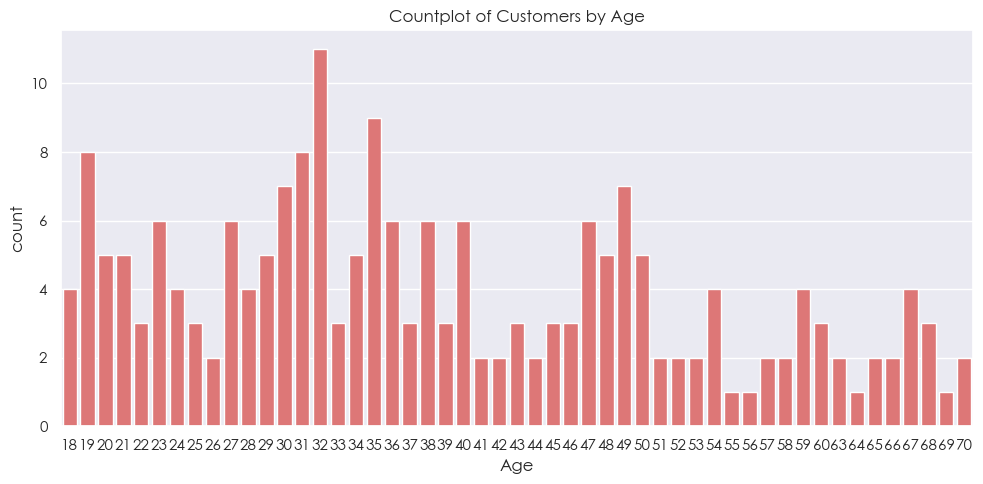

In [12]:
# Plot count plot of customer's age
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data=customer,x='Age',ax=ax,color="#ee6666").set(title='Countplot of Customers by Age')
plt.tight_layout()
plt.show()

**ANALYSIS OF CHART 2:** 

From the count of customers by age, we can see that most customers are 32 years old, and we can also see that most customers tend to be at ages of 18 to 50, whilst there are fewer customers aged 50 and above. This might be possibly due to the nature of my mall's attractions, and how we advertise oursevles. This shows that most consumers of my shopping mall tend to be young adults in their twenties to thirties.

### **CHART 3: COUNT OF CUSTOMERS AND AVERAGE SPENDING SCORE BY GENDER**

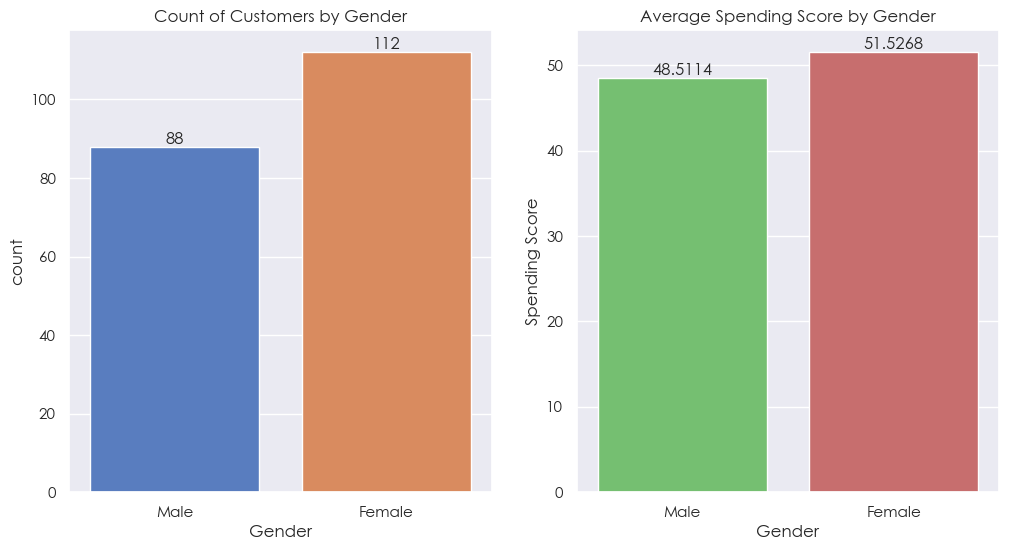

In [13]:
# Plot of count of customers and average spending score by gender
fig,axs = plt.subplots(1,2,figsize=(12,6))
sns.countplot(x=customer['Gender'],ax=axs[0],palette=muted).set(title='Count of Customers by Gender')
sns.barplot(x=customer['Gender'],y=customer['Spending Score'],ax=axs[1],palette=muted[2:],errorbar=None).set(title='Average Spending Score by Gender')
axs[0].bar_label(axs[0].containers[0])
axs[1].bar_label(axs[1].containers[0])
plt.show()

**ANALYSIS OF CHART 3:** 

We can also see that females tend to have a higher spending score compared to males, and there are more females that shop at the mall compared to males, hence since most of the mall's consumers tend to be female, the mall should be more focused in catering towards them.

### **CHART 4: DISTRIBUTION OF NUMERIC VARIABLES IN CUSTOMER DATASET**

Skewness of Income (k$): 0.3218425498619055
Skewness of Spending Score: -0.047220201374263374


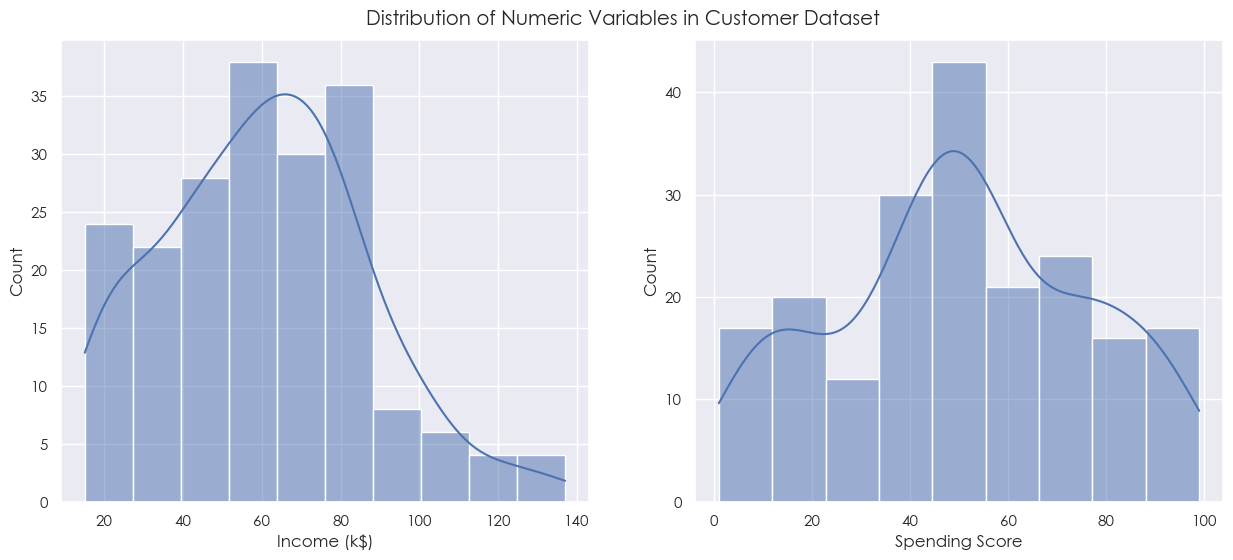

In [14]:
# Plot histogram of numeric variables and print skewness coefficient 
print("Skewness of Income (k$): " + str(customer['Income (k$)'].skew()) + "\nSkewness of Spending Score: " + str(customer['Spending Score'].skew()))
fig,ax = plt.subplots(1,2,figsize=(15,6))
sns.histplot(customer['Income (k$)'],ax=ax[0],kde=True)
sns.histplot(customer['Spending Score'],ax=ax[1],kde=True)
fig.suptitle("Distribution of Numeric Variables in Customer Dataset",y=0.93)
plt.show()

**ANALYSIS OF CHART 4:**

 We can see that the Spending Score data is normally distributed, however, the income data is slightly right-skewed.
 
 We can also see that most customers tend to be in the middle income group with incomes from around 60-70k$ and have an average spending score of around 40 to 60 in the mall.

### **CHART 5: REGRESSION PLOT OF INCOME AGAINST SPENDING SCORE**

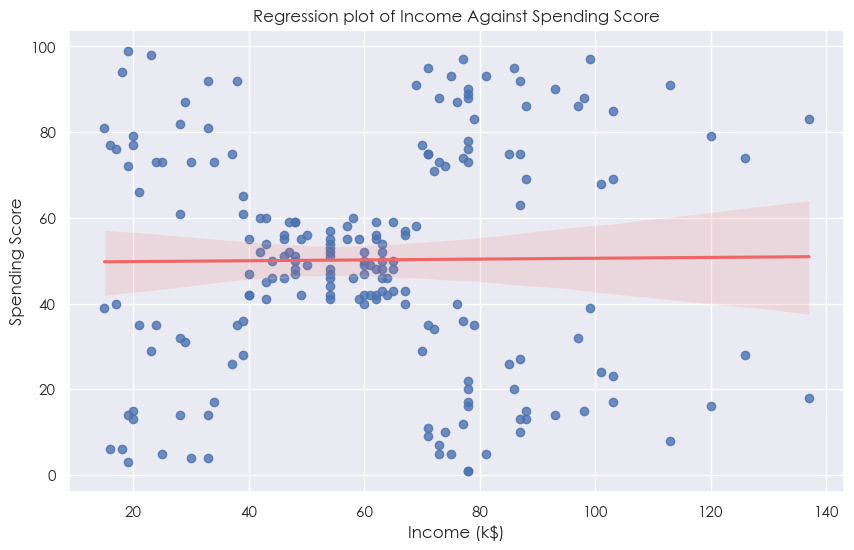

In [15]:
# Plot regression plot of income against Spending Score
fig,axs = plt.subplots(figsize=(10,6))
sns.regplot(x=customer['Income (k$)'],y=customer['Spending Score'],line_kws={'color':'#ee6666'},ax=axs).set(title='Regression plot of Income Against Spending Score')
plt.show()

**ANALYSIS OF CHART 5:**

From the regression plot, we can see that there is no correlation between the two variables, however, we can see distinct clusters that are formed, such as top-left being being low income but high spending score, or bottom-right being high income but low spending score. We can also see that customers that are of low or high income tend to either have a high or low spending score only, whilst customers of middle income have an average spending score.

Hence, we can see that the customers can likely be grouped based on their spending score and income into distinct clusters.

## **3. FEATURE ENGINEERING**

### **ONE-HOT ENCODING FEATURES**

pd.get_dummies() was used to encode the categorical feature, Gender, into a binary representation where if Gender_Male = 1, the customer is a male, otherwise if Gender_Male = 0, the customer would be a female. By performing one-hot encoding, it allows the algorithm to utilise the gender column in its clustering.

In [16]:
# Encode categorical feature Gender
customer_dummy = pd.get_dummies(customer,drop_first=True)
customer_dummy.head(5)

,Age,Income (k$),Spending Score,Gender_Male
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0


### **OUTLIER CHECK**

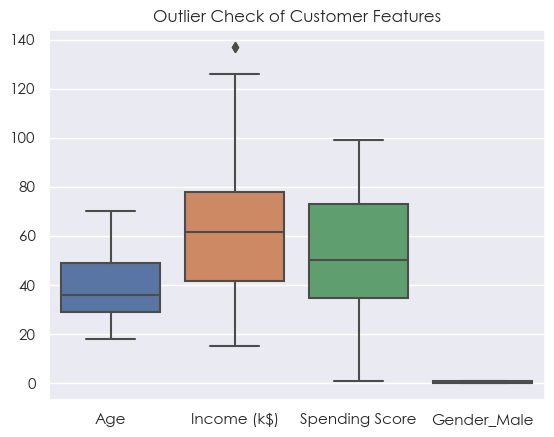

In [17]:
# Outlier check
sns.boxplot(customer_dummy).set(title='Outlier Check of Customer Features')
plt.show()

We can see that there are almost no outliers except one from Income (k$), and hence there are not much outliers that would heavily impact our algorithm negatively. Hence handling outliers is not required.

### **PCA [NOT IMPLEMENTED]**

In [18]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=4, random_state=42)
# customer_reduced = pd.DataFrame(pca.fit_transform(customer_dummy))
# def pca_results(data, pca):
    
#     # Dimension indexing
#     dimensions = ['PC {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
#     # PCA components
#     components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
#     components.index = dimensions

#     #PCA eigenvalues
#     ev = pca.explained_variance_.reshape(len(pca.components_), 1)
#     eigenvalues = pd.DataFrame(np.round(ev, 4), columns = ['Eigenvalue']) 
#     eigenvalues.index = dimensions
    
#     # PCA explained variance
#     ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
#     variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
#     variance_ratios.index = dimensions

#     # PCA cumulative explained variance
#     variance_ratios['Cumulative variance'] = variance_ratios['Explained Variance'].cumsum()
        
#     # Return a concatenated DataFrame
#     return pd.concat([eigenvalues, variance_ratios, components], axis = 1)
# pca_results(customer_dummy,pca)

PCA was NOT implemented as we already have very little features (4) to work with, and hence no features should be dropped.

### **FEATURE SCALING [NOT IMPLEMENTED]**

Feature scaling was not implemented in the final algorithms as:

- The scale and range of different features do not deviate much from one another
- Feature scaling seemed to worsen the model's predictions during clustering, leading to poorer silhouette scores and interpretability

Hence, I chose to not scale features in the end. However, I still tested scaled on the baseline K-Means algorithm to reinforce my decision in not doing so, shown below.

In [19]:
# Import modules needed
from sklearn.preprocessing import StandardScaler
# Instantiate scaler
scaler = StandardScaler()
# Get columns
columns = customer_dummy.columns
# Scale first three columns (excluding Gender_Male)
scaler.fit(customer_dummy.iloc[:,:3])
customer_scaled = pd.DataFrame(scaler.transform(customer_dummy.iloc[:,:3]),columns=columns[:3])
customer_scaled['Gender_Male'] = customer_dummy.iloc[:,3]
customer_scaled

,Age,Income (k$),Spending Score,Gender_Male
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0
...,...,...,...,...
195,-0.276302,2.268791,1.118061,0
196,0.441365,2.497807,-0.861839,0
197,-0.491602,2.497807,0.923953,1
198,-0.491602,2.917671,-1.250054,1


**View distribution of each column's values after scaling**

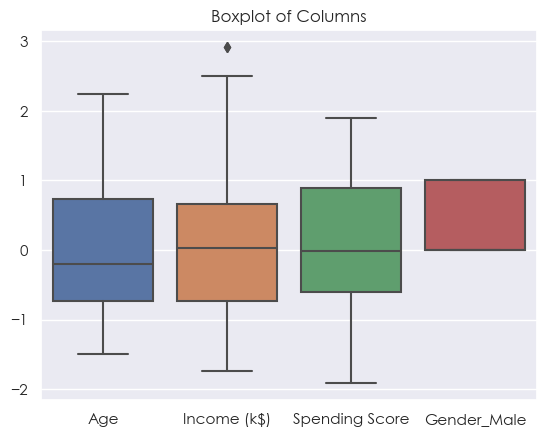

In [20]:
sns.boxplot(customer_scaled).set(title='Boxplot of Columns')
plt.show()

We can see that from scaling, now the ranges of the values are roughly the same and do not differ much from one another.

However, from utilising scaled data, results from clustering were poorer compared to using unscaled data as shown below on the baseline K-Means Algorithm.

**FUNCTION(S) FOR DETERMINE NUMBER OF CLUSTERS, K**

This was meant to be in 4. but was shifted here as I needed it to demonstrate the silhouette analysis of scaled data

In [24]:
# Lineplot for silhouette coefficient function
def silScore(model,X,plot):
    silScores = []
    header =  "-"*6 + "Silhouette Score For Each n_cluster" + "-"*6
    print("x" + header + "x")
    for k in range(2, 11):
        model = model.set_params(n_clusters=k).fit(X)
        label = model.labels_
        sil_coeff = silhouette_score(X, label, metric='euclidean')
        silScores.append(sil_coeff)
        print("For n_clusters={}, The Silhouette Score is {:.3f}".format(k,sil_coeff))
    print("x" + "-"*len(header) + "x")
    if plot:
        sns.lineplot(x=range(2,11),y=silScores,marker='s',color='#ee6666').set(title='Silhouette Score Plot',xlabel='N_Clusters',ylabel='Silhouette Score')
        plt.ylim(0.2,0.5)

x------Silhouette Score For Each n_cluster------x
For n_clusters=2, The Silhouette Score is 0.303
For n_clusters=3, The Silhouette Score is 0.314
For n_clusters=4, The Silhouette Score is 0.350
For n_clusters=5, The Silhouette Score is 0.350
For n_clusters=6, The Silhouette Score is 0.356
For n_clusters=7, The Silhouette Score is 0.336
For n_clusters=8, The Silhouette Score is 0.336
For n_clusters=9, The Silhouette Score is 0.341


For n_clusters=10, The Silhouette Score is 0.322
x-----------------------------------------------x


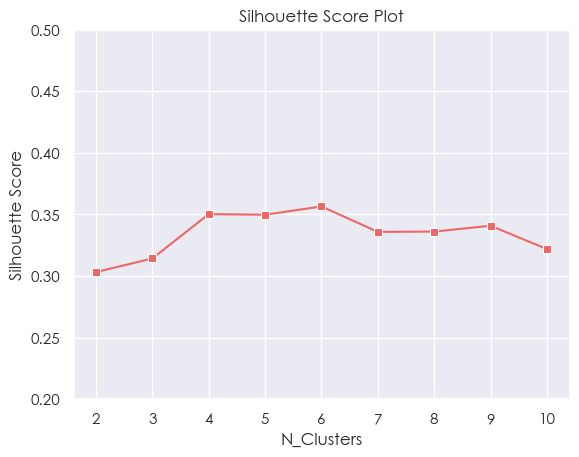

In [26]:
# Import modules
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Function for silhouette analysis
kmean = KMeans()
silScore(kmean,customer_scaled,True)

From the silhouette analysis, we identify that the scaled data performs best on the K-Means Algorithm with n_clusters = 4, 5 or 6. Hence, now we will plot the clusters to see how they performed.

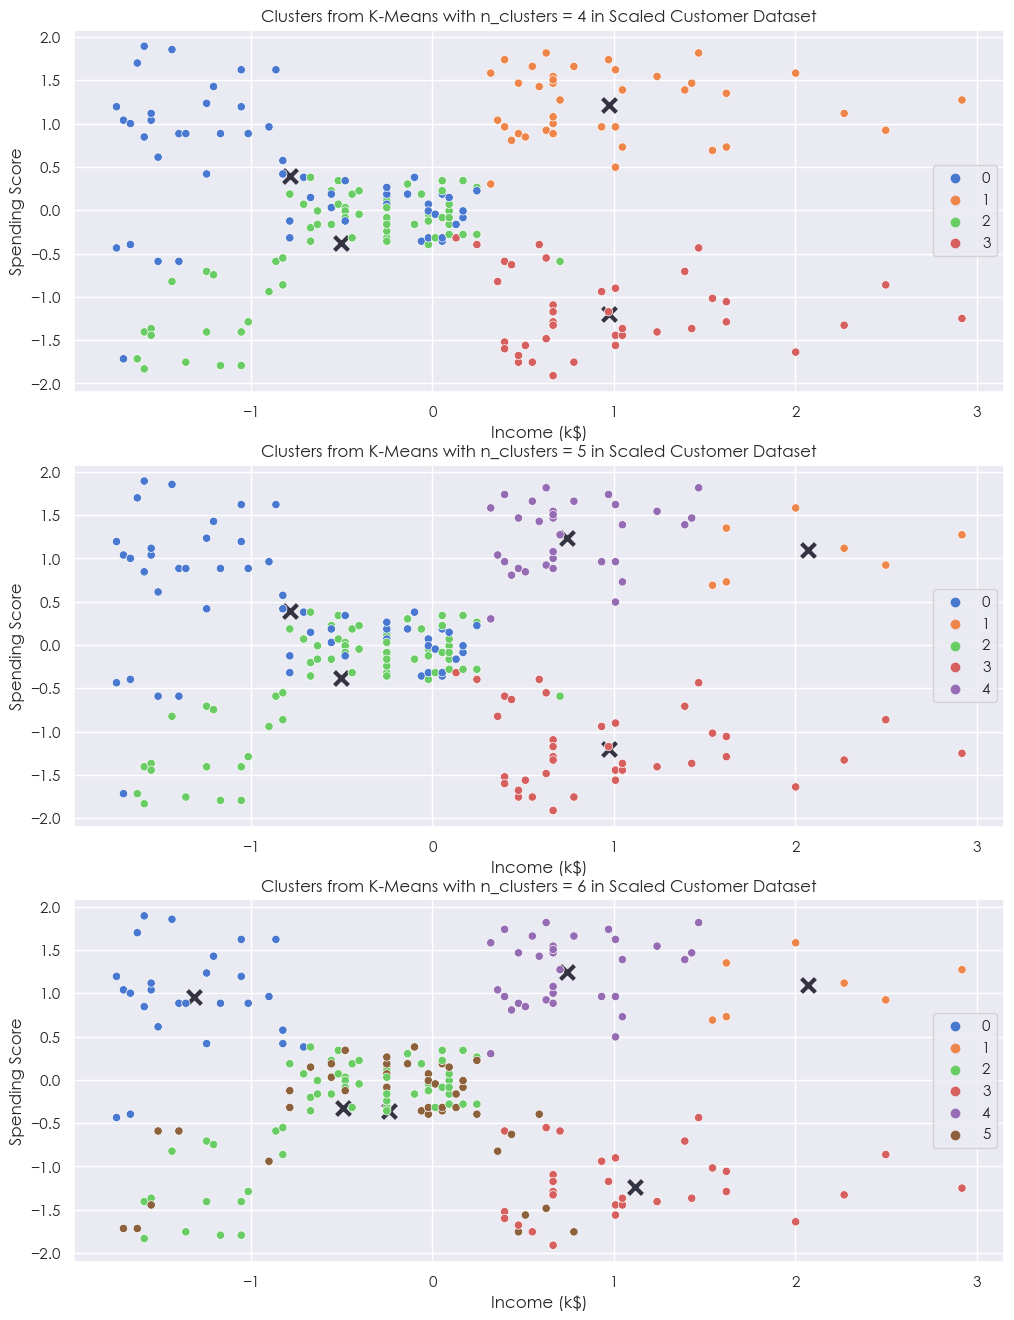

In [27]:
fig,axs = plt.subplots(3,1,figsize=(12,16))
cnt = 0
# Loop for values of n_cluster of 5,6,7 and plot the model's results
for x in [4,5,6]:
    kmean = KMeans(n_clusters=x,n_init='auto',random_state=1)
    kmean.fit(customer_scaled)
    labels = kmean.labels_
    cc = kmean.cluster_centers_
    sns.scatterplot(ax=axs[cnt],x=cc[:,1],y=cc[:,2],color='#343341',marker='x',s=100,linewidth=3)
    sns.scatterplot(ax=axs[cnt],x=customer_scaled['Income (k$)'],y=customer_scaled['Spending Score'],hue=labels,palette='muted').set(title='Clusters from K-Means with n_clusters = ' + str(x) + " in Scaled Customer Dataset")
    cnt += 1

From this, we can see how poorly the scaled dataset is clustered with the best three forming n_clusters value in terms of silhouette score, where there are overlaps of clusters even with the best silhouette scores, preventing us from extracting valuable insights from each cluster as they are unclear, and when compared to unscaled data (which will be shown below), we can see a great difference in performance during clustering even with the same baseline K-Means Algorithm as it provides distinct clusters and allows us to gather insights on each cluster with clarity, and hence that would reinforce my decision on not scaling my features. 

## **4. DETERMINE NUMBER OF CLUSTERS K AND HYPERPARAMETER TUNING**

Before algorithm selection, the number of clusters have to be determined first, and for algorithms that do not require specifying the number of clusters, hyperparameter tuning would be done instead if an error is raised when default hyperparameters are used. This helps to ensure that the algorithms compared during the selection are fair.

<span style='font-size:22px;'>**DETERMINE NUMBER OF CLUSTERS, K**

Before we start determine which algorithm to select as our final algorithm, we must first determine the number of clusters that are going to be created. Hence, the methods stated down below are a few that I have utilized to do so.

**Methods:**
- Elbow plot
- Dendrogram
- Silhouette score analysis
- Visual inspection

**ELBOW PLOT**

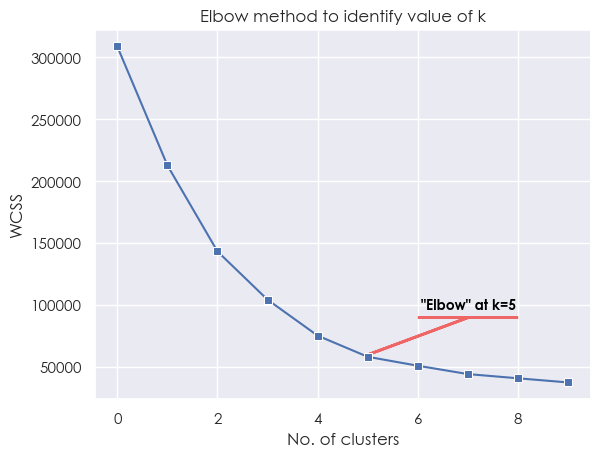

In [28]:
# Import modules
from sklearn.cluster import KMeans
# Obtain WCSS values
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(customer_dummy)
    wcss.append(kmeans.inertia_)
# Plot elbow plot
sns.lineplot(wcss,marker='s')
plt.text(7, 100000,'"Elbow" at k=5', color='black', ha='center', va='center', fontsize=10,fontdict={'fontweight':'bold'})
plt.arrow(5, 60000,2,30000, head_width=2, head_length=0, linewidth=2, color='#ee6666')
plt.title('Elbow method to identify value of k')
plt.xlabel('No. of clusters')
plt.ylabel('WCSS')
plt.show()

**Elbow Plot Analysis:**

WCSS -> Within-cluster sum of squares ->  The sum of the squared distance between each member of the cluster and its centroid.

We can see that from the elbow plot, the elbow is at k=5 as after k=5, the curve starts to flatten and is no longer steep. Hence, the number of clusters, k, should be 5.

**DENDROGRAM OF CUSTOMERS FOR HIERARCHICAL CLUSTER ANALYSIS**

This is mainly used to determine number of clusters (k) for hierarchical clustering algorithms such as AgglomerativeClustering.

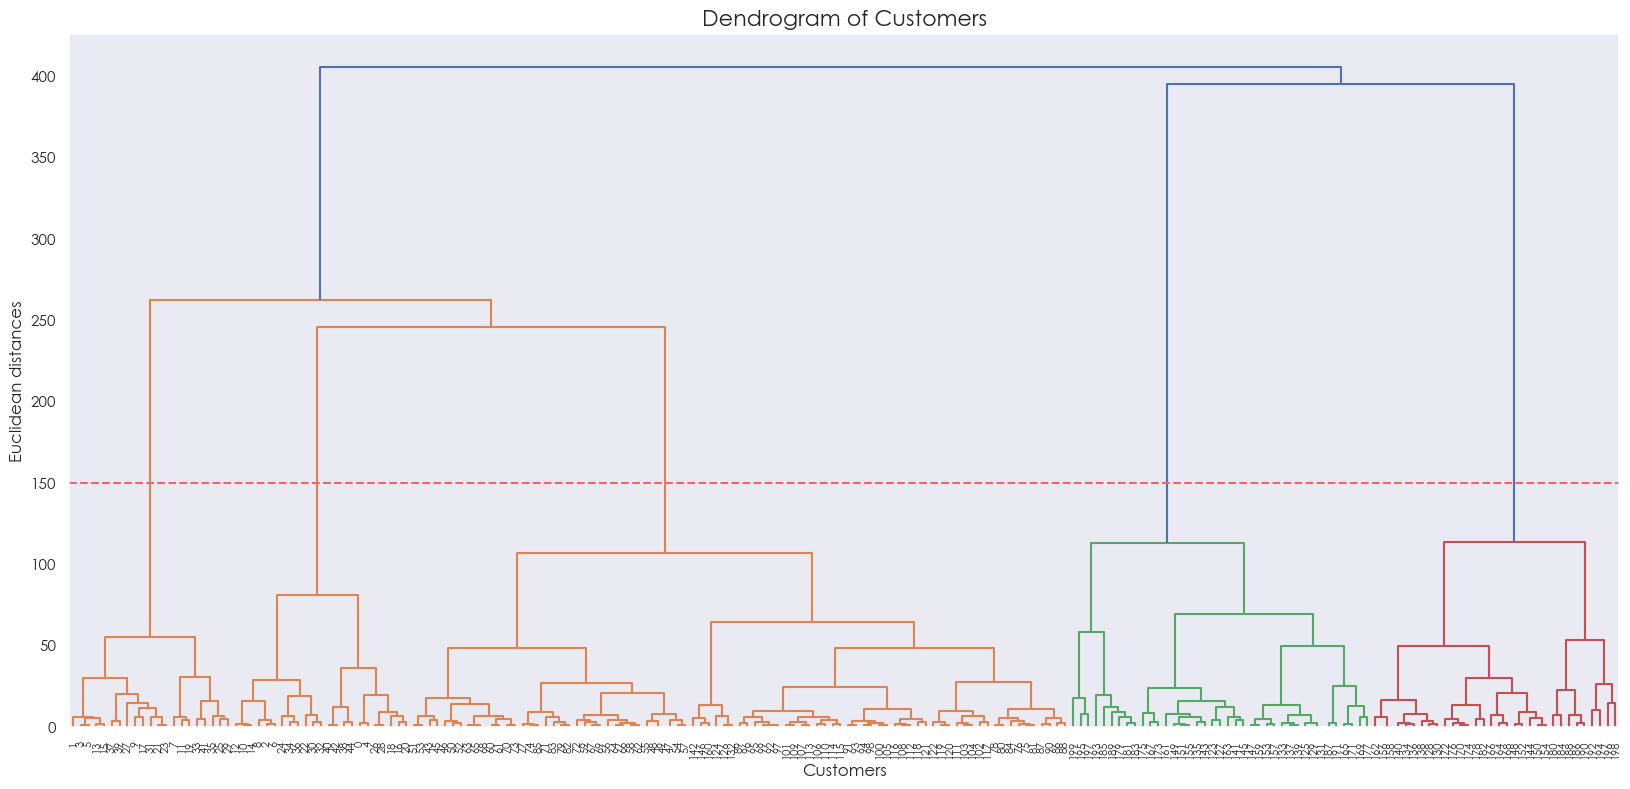

In [29]:
# Import modules
from scipy.cluster import hierarchy
# Variable for target columns
X = customer_dummy[['Spending Score','Income (k$)']]
# Plot dendrogram
plt.figure(figsize=(20,9))
dendrogram = hierarchy.dendrogram(hierarchy.linkage(X, method = 'ward'),leaf_font_size=8)
plt.axhline(y=150,linestyle='dashed',color='#ee6666')
plt.title('Dendrogram of Customers',fontdict={'fontsize':16})
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.grid(False)
plt.xticks(rotation=90)
plt.show()

**Dendrogram Analysis:**

Height -> Distance between clusters

We can see that the optimal k value from the dendrogram would be 5 as at number of clusters = 5, the clusters deviate far enough from one another to show variation shown by the higher euclidean distance when n_clusters = 5 compared to any other n_cluster value.

We can also see that the horizontal dotted line shows that k should be 5 to provide a stable number of clusters without much change in number of clusters as the horizontal line moves back and forth.

**SILHOUETTE ANALYSIS**

x------Silhouette Score For Each n_cluster------x
For n_clusters=2, The Silhouette Score is 0.293
For n_clusters=3, The Silhouette Score is 0.384
For n_clusters=4, The Silhouette Score is 0.405
For n_clusters=5, The Silhouette Score is 0.444
For n_clusters=6, The Silhouette Score is 0.452
For n_clusters=7, The Silhouette Score is 0.441
For n_clusters=8, The Silhouette Score is 0.426
For n_clusters=9, The Silhouette Score is 0.415
For n_clusters=10, The Silhouette Score is 0.375
x-----------------------------------------------x


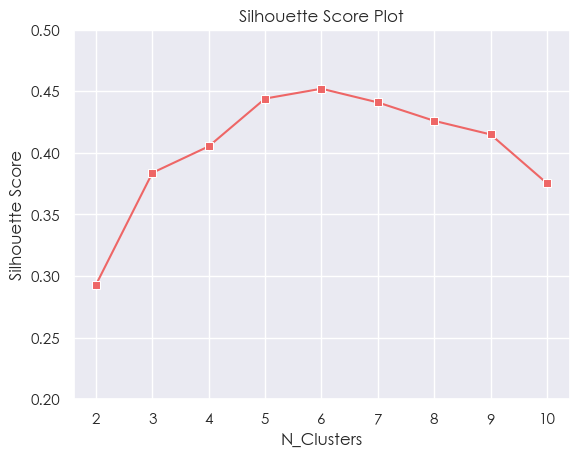

In [30]:
# Function for silhouette analysis
kmean = KMeans()
silScore(kmean,customer_dummy,True)

**Silhouette Analysis:**

From the silhouette plot, we can see that the highest silhouette score is when n_clusters = 6, followed by n_clusters = 7 then n_clusters = 5.

**VISUAL INSPECTION**

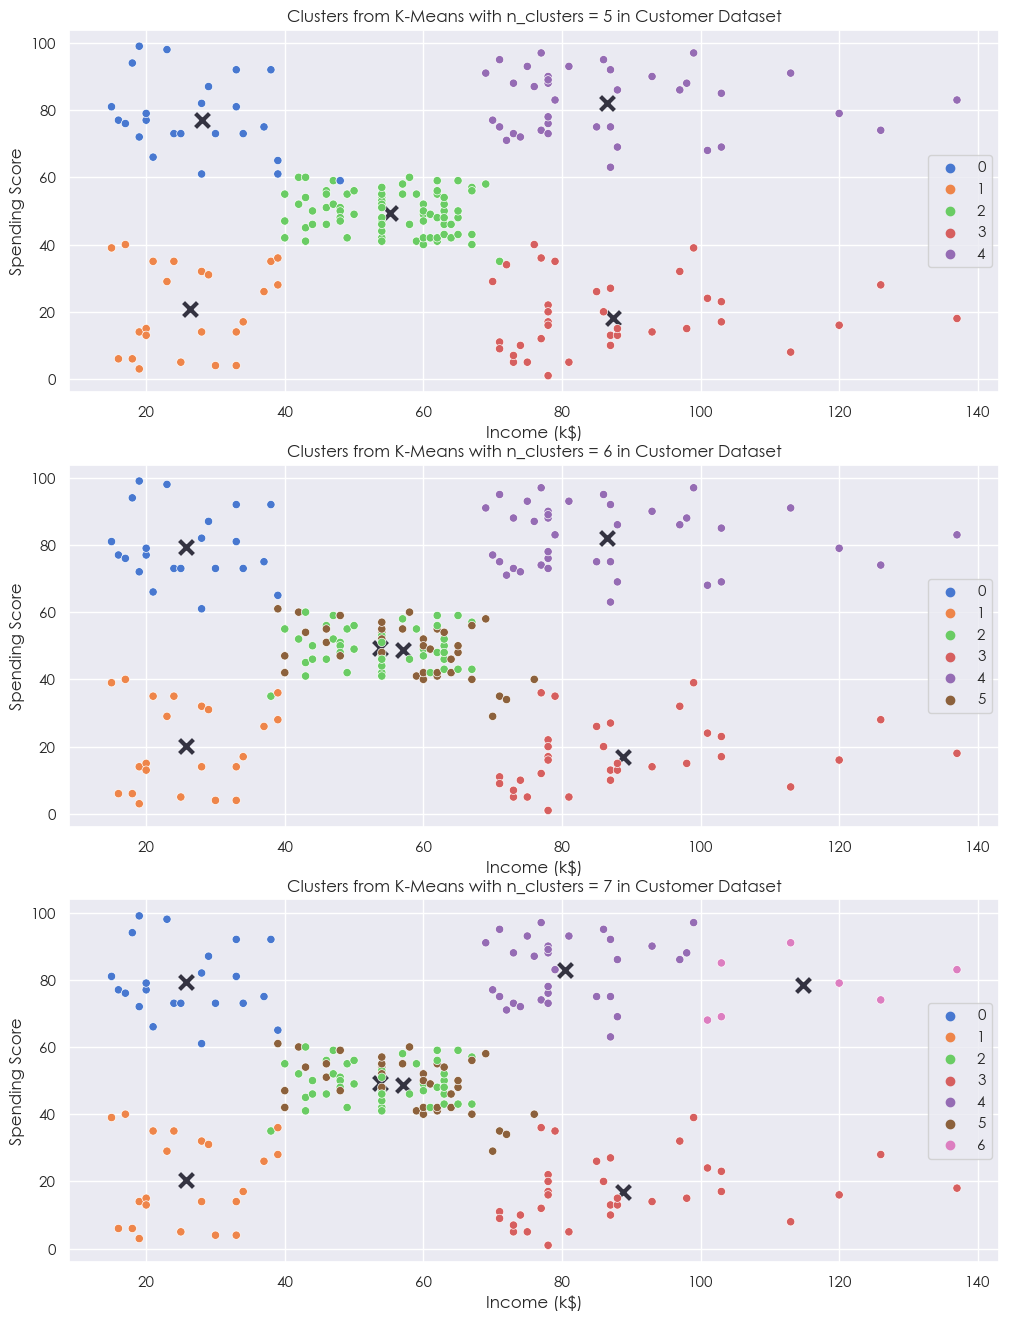

In [31]:
fig,axs = plt.subplots(3,1,figsize=(12,16))
cnt = 0
# Loop for values of n_cluster of 5,6,7 and plot the algorithm's results
for x in [5,6,7]:
    kmean = KMeans(n_clusters=x,n_init='auto',random_state=1)
    kmean.fit(customer_dummy)
    labels = kmean.labels_
    cc = kmean.cluster_centers_
    sns.scatterplot(ax=axs[cnt],x=cc[:,1],y=cc[:,2],color='#343341',marker='x',s=100,linewidth=3)
    sns.scatterplot(ax=axs[cnt],x=customer_dummy['Income (k$)'],y=customer_dummy['Spending Score'],hue=labels,palette='muted').set(title='Clusters from K-Means with n_clusters = ' + str(x) + " in Customer Dataset")
    cnt += 1

**Visual Inspection Analysis:**

However, from visual inspection, we can clearly see that the best value of n_clusters would be 5, as n_clusters of 6 or 7 do not show distinct clusters and there are clusters that are mixed within one another, providing inaccurate clusterings and may lead to misleading interpretations. Whilst n_clusters of 5 provides distinct clusters separated clearly from one another, allowing us to extract knowledge and information for each distinct cluster.

**CONCLUSION OF NUMBER OF CLUSTERS:**

In conclusion, from the elbow plot, dendrogram, silhouette score plot and visual inspection, it is clearly evident that the number of clusters created should be 5.

<span style='font-size:22px;'>**HYPERPARAMETER TUNING**

Hyperparameter tuning is done for algorithms that do not require specifying the number of clusters specifically and when the default hyperparameters were utilized, an error is shown.


Different hyperparameters would be tuned and the best hyperparameters would be identified with the highest silhouette scores.

**ALGORITHMS TO BE TUNED:**
- MeanShift
- DBSCAN
- Gaussian Mixture

**MEANSHIFT CLUSTERING ALGORITHM**

By performing hyperparameter tuning onto the quantile hyperparameter in estimate_bandwidth, we would get different values of bandwidth hyperparameter for the MeanShift algorithm, affecting the way the algorithm performs and its numbers of clusters, and this would be to test whether the algorithm can be improved.

Quantile were tested at smaller values so that clusters formed are more tight and focused for better results.

x-----Hyperparameter Tuning for Quantile-----x
Quantile: 0.08 => Silhouette score: 0.39669
Quantile: 0.09 => Silhouette score: 0.4156
Quantile: 0.1 => Silhouette score: 0.44306
Quantile: 0.11 => Silhouette score: 0.43469
Quantile: 0.12 => Silhouette score: 0.44306
Quantile: 0.13 => Silhouette score: 0.40444
Quantile: 0.14 => Silhouette score: 0.40812
Quantile: 0.15 => Silhouette score: 0.42355
Quantile: 0.16 => Silhouette score: 0.40619
Quantile: 0.17 => Silhouette score: 0.36458
Quantile: 0.18 => Silhouette score: 0.37082
x--------------------------------------------x


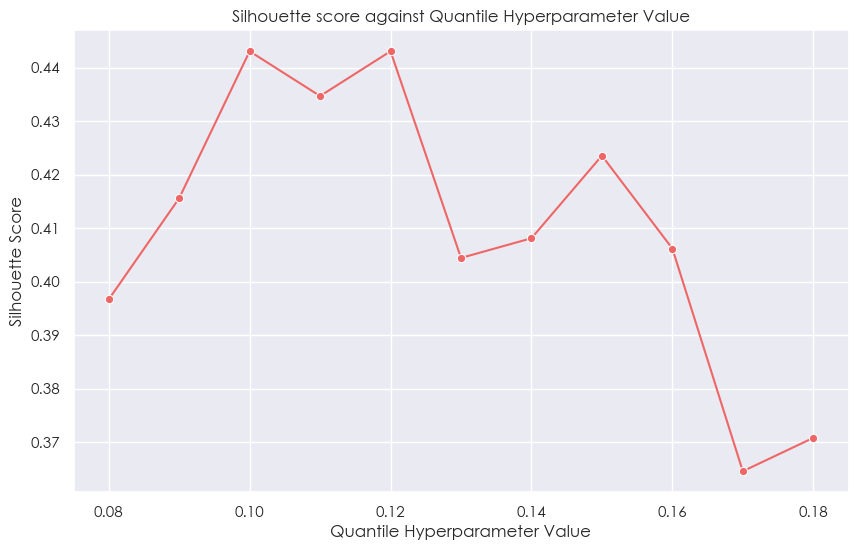

In [32]:
# Import modules
from sklearn.cluster import MeanShift, estimate_bandwidth
# Hyperparameter tuning for quantile
# Variables
quantile_values = [0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18]
scores = []
best_quantile = np.inf
best_score = 0
# Print header
tuningheader =  "-"*5 + "Hyperparameter Tuning for Quantile" + "-"*5
print("x" + tuningheader + "x")
# Loop each quantile value and obtain silhouette score to print and store
for x in range(len(quantile_values)):
    bandwidth = estimate_bandwidth(customer_dummy, quantile=quantile_values[x])
    ms = MeanShift(bandwidth=bandwidth).fit(customer_dummy)  
    label = ms.labels_
    score = round(silhouette_score(customer_dummy, label, metric='euclidean'),5)
    scores.append(score)
    print('Quantile: ' + str(quantile_values[x]) + " => Silhouette score: " + str(score))
    if score > best_score:
        best_score = score
        best_quantile = quantile_values[x]
# Close printing line
print("x" + '-' * len(tuningheader) + "x")
# Plot lineplot of silhouette score
fig,ax = plt.subplots(figsize=(10,6))
sns.lineplot(x=quantile_values,y=scores,ax=ax,color='#ee6666',marker='o').set(title='Silhouette score against Quantile Hyperparameter Value',
                                                                              xlabel='Quantile Hyperparameter Value',
                                                                              ylabel='Silhouette Score'
                                                                              )
plt.show()

We can see that the silhouette score is the highest with 0.44306 at quantile values of 0.10 or 0.12, hence either values should be used as the quantile  hyperparameter for optimal performance of the algorithm.

**DBSCAN**

Hyperparameters to be tuned for DBSCAN would be eps and min_samples. Permutations of those two values would be tested to identify the permutation with the highest silhouette scores.

**eps** => maximum distance between two samples for one to be considered as in the neighbourhood of the other

**min_samples** => minimum number of samples in a neighbourhood for a point to be considered as a core point

In [33]:
# Import modules needed
import itertools
from tqdm.notebook import tqdm
from sklearn.cluster import DBSCAN
# Parameter grid/ Variables for hyperparameters to be tested
eps_params = range(10,20)
min_samples_params = range(5,15)
# Dictionary for results
results = {}
# Itertools to get all combinations of hyperparameters
hyperparameter_combi = itertools.product(eps_params,min_samples_params)
# Turn iterator into a list
list_hyperparameter_combi = list(hyperparameter_combi)
# Iterate over list of hyperparameter combinations with tqdm for progress BAR [total => total number of iterations to be completed]
for params in tqdm(list_hyperparameter_combi, desc="Processing", total=len(list_hyperparameter_combi)):
    eps, min_samples = params
    hyp = "eps=" + str(eps) + " | min_samples=" + str(min_samples) 
    dbs = DBSCAN(eps=eps,min_samples=min_samples).fit(customer_dummy)
    label = dbs.labels_
    score = silhouette_score(customer_dummy, label, metric='euclidean')
    results[hyp] = round(score,3)
# Convert dictionary of results into DataFrame
results = pd.DataFrame.from_dict(results,orient='index',columns=['Silhouette Score'])
# Get lowest MAPE score's index
best_index = results['Silhouette Score'].idxmax()
# Print best results
header = "-"*10+ "Hyperparameter Tuning Results" + "-"*10
print(header + "\nBest hyperparameter: " + best_index + "\nBest Silhouette score: " + str(results.loc[best_index,:]['Silhouette Score']) + "\n" + "-"*len(header))
# Store best hyperparameters
best_eps = int(best_index.split('|')[0].split('=')[1])
best_min_samples = int(best_index.split('|')[1].split('=')[1])

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

----------Hyperparameter Tuning Results----------
Best hyperparameter: eps=19 | min_samples=6
Best Silhouette score: 0.377
-------------------------------------------------


**GAUSSIAN MIXTURE**

Hyperparameter tuning for Gaussian Mixture was done on the n_components hyperparameter.

x--Hyperparameter tuning for Gaussian Mixture--x
n_components = 2 => Silhouette Score = 0.3115
n_components = 3 => Silhouette Score = 0.2999
n_components = 4 => Silhouette Score = 0.3775
n_components = 5 => Silhouette Score = 0.4341
n_components = 6 => Silhouette Score = 0.4455
n_components = 7 => Silhouette Score = 0.4201
n_components = 8 => Silhouette Score = -0.0912
n_components = 9 => Silhouette Score = -0.1577
n_components = 10 => Silhouette Score = -0.128
x----------------------------------------------x


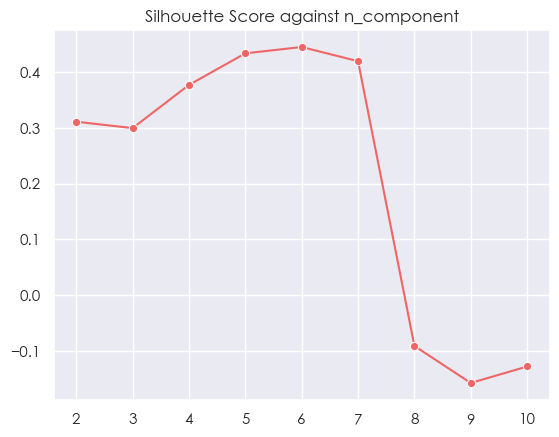

Best n_component = 6


In [34]:
# Import modules needed
from sklearn.mixture import GaussianMixture
# Hyperparameter tuning
n_components = range(2,11)
silhouette_array = []
header = "-"*2 + "Hyperparameter tuning for Gaussian Mixture" + '-'*2
print("x"+header+"x")
best_n_component = np.inf
best_silhouette = 0
for i in n_components:
    gmm = GaussianMixture(n_components=i,random_state=1).fit(customer_dummy)
    pred = gmm.predict(customer_dummy)
    score = silhouette_score(customer_dummy, pred, metric='euclidean')
    silhouette_array.append(score)
    print("n_components = " + str(i) + " => Silhouette Score = " + str(round(score,4)))
    if score > best_silhouette:
        best_silhouette = score
        best_n_component = i
print("x"+'-'*len(header)+"x")
sns.lineplot(x=n_components,y=silhouette_array,color='#ee6666',marker='o').set(title='Silhouette Score against n_component')
plt.show()
print("Best n_component = " + str(best_n_component))

Now, we have decided the number of clusters, k and determined the hyperparameters of other algorithms that do not require specification of number of clusters, k. We can then proceed on to compare these algorithms to determine the best algorithm to utilize.

## **5. ALGORITHM SELECTION**

**Methods:**
- Scatterplot To View Clusters
- Silhouette Score
- Davies-Bouldin Index [NOT IMPLEMENTED] => Misleading scoring when number of clusters are different.

**Clustering Algorithms Tested:**
- K-Means **[BASELINE]**
- Agglomerative
- DBSCAN
- Mean Shift
- Spectral
- Affinity Propagation

**FUNCTIONS FOR ALGORITHM SELECTION**

In [35]:
# Function for evaluation results
def evalResult(data,label,algName):
    print("Evaluation Results:\n"+'-'*61)
    print('Silhouette score for ' + algName + ': ' + str(round(silhouette_score(data,label,metric='euclidean'),3)))
    print('-'*61)

# Scatterplot for cluster analysis function
def scatterPlot(x,y,label,algName,cc):
    fig,ax = plt.subplots(figsize=(10,6))
    # Change labels and order labels
    label = ["Cluster " + str(n+1) for n in label]
    order = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5']
    # Plot scatterplot
    sns.scatterplot(x=x,y=y,hue=label,hue_order=order,palette='muted',ax=ax).set(title="Clusters from " + algName + " in Customer Dataset")
    # Plot cluster centers
    sns.scatterplot(x=cc[:,1],y=cc[:,2],ax=ax,color='#343341',marker='x',s=100,linewidth=3)
    plt.show()



### **COMPARING CLUSTERING ALGORITHMS**

I compared clustering algorithms such as KMeans, Gaussian Mixture, MeanShift, DBSCAN, AgglomerativeClustering and AffinityPropagation in order to find the best clustering algorithm with the **best silhouette score** and **best clusters from visual inspection**.

The number of clusters for K-Means was determined to be 5 by the elbow plot earlier.

The number of clusters for agglomerative clustering was determined to be 5 by the dendrogram earlier.

The hyperparameters for other clustering algorithms were tuned previously and would be utilized here to determine the best algorithm, otherwise, algorithms that allowed for default hyperparameters without errors were utilized with default hyperparameters.

x--------------------Silhouette Scores for each Clustering Algorithm--------------------x
For the K-Means algorithm, the silhouette coefficient is 0.44
For the Agglomerative Clustering algorithm, the silhouette coefficient is 0.44
For the DBSCAN algorithm, the silhouette coefficient is 0.377
For the Gaussian Mixture algorithm, the silhouette coefficient is 0.446
For the MeanShift algorithm, the silhouette coefficient is 0.443
For the Affinity Propagation algorithm, the silhouette coefficient is 0.346
x---------------------------------------------------------------------------------------x


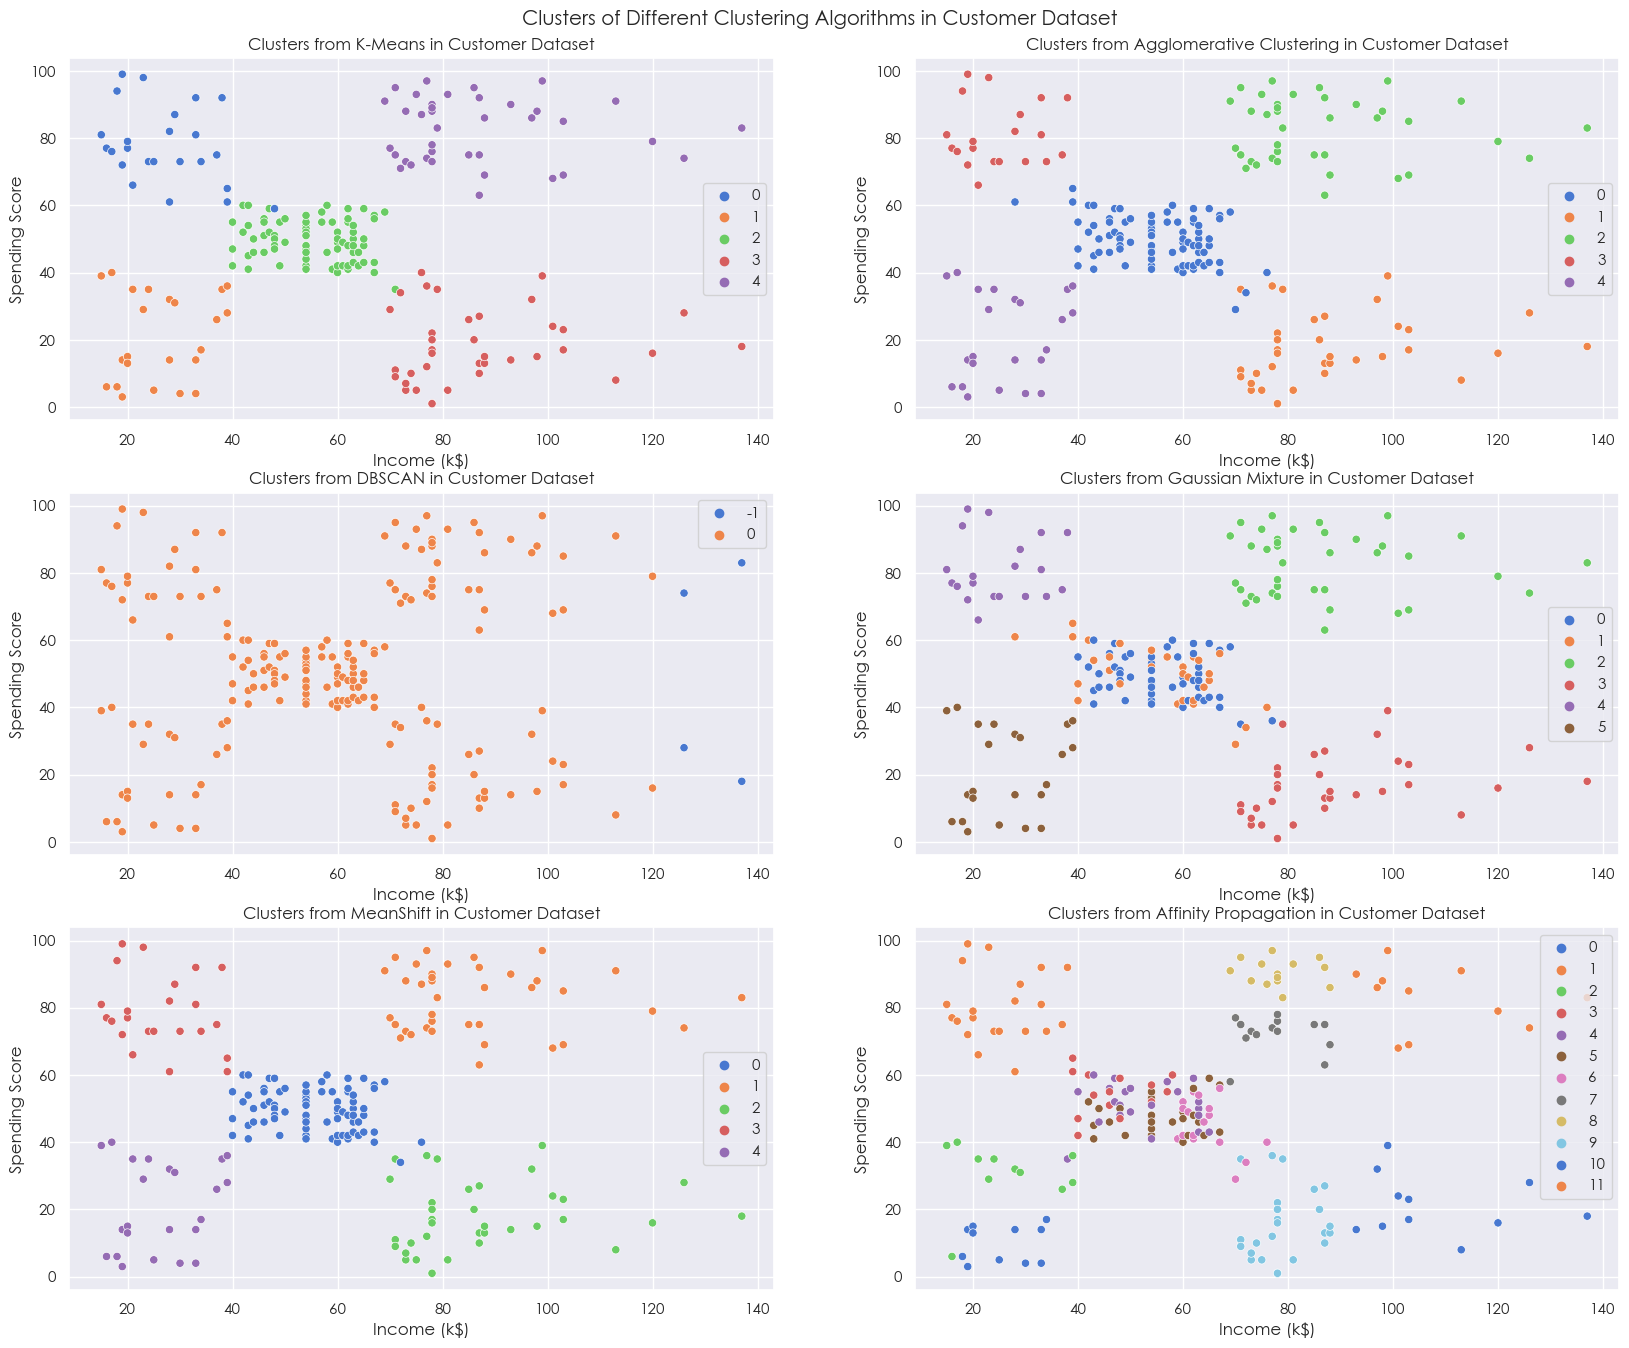

In [36]:
# Import modules
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation
# For MeanShift algorithm
bandwidth = estimate_bandwidth(customer_dummy, quantile=best_quantile)
# n_clusters value from earlier
n_clusters = 5
# Models dictionary with every clustering algorithm to be tested
models = {
    'K-Means': KMeans(n_clusters=n_clusters,n_init='auto',random_state=1),
    "Agglomerative Clustering": AgglomerativeClustering(n_clusters=n_clusters), 
    'DBSCAN': DBSCAN(eps=best_eps,min_samples=best_min_samples),
    'Gaussian Mixture': GaussianMixture(n_components=best_n_component),
    'MeanShift': MeanShift(bandwidth=bandwidth),
    'Affinity Propagation': AffinityPropagation()
    }
# Array to store results of scorings
silArray = []
# Plotting of scatterplots for each model
fig,axs = plt.subplots(3,2,figsize=(20,16))
fig.suptitle(t='Clusters of Different Clustering Algorithms in Customer Dataset',y=0.91)
rowNo, colNo, count = 0, 0, 0
for model in models.values():
    model.fit(customer_dummy)
    try:
        label = model.predict(customer_dummy)
    except:
        label = model.labels_
    sns.scatterplot(ax=axs[rowNo][colNo],
                    x=customer['Income (k$)'],
                    y=customer['Spending Score'],
                    hue=label,
                    palette='muted').set(title='Clusters from ' + list(models.keys())[count] + ' in Customer Dataset')
    silArray.append(silhouette_score(customer_dummy, label, metric='euclidean'))
    colNo += 1
    count += 1
    if colNo > 1:
        rowNo +=1
        colNo = 0
# Print Silhouette Score for each model
header = "-"*20 + 'Silhouette Scores for each Clustering Algorithm' + "-"*20
print("x" + header + 'x')
for x in range(len(silArray)):
    print('For the {} algorithm, the silhouette coefficient is {}'.format(list(models.keys())[x],round(silArray[x],3)))
print("x" + '-' * len(header) + 'x')

**ANALYSIS OF COMPARISON OF CLUSTERING ALGORITHMS:**

From the evaluation results, we can see that the best performing clustering algorithm was Gaussian Mixture with a silhouette score of 0.446, followed by Meanshift Clustering Algorithm with 0.443, then K-Means and Agglomerative Clustering at 0.44. However, from visual inspection, we can see that the clusters made from Gaussian Mixture overlap, and are not distinct enough for us to interpret the results, hence the next best clustering algorithm that had the highest evaluation result and most clear and distinct clusters would be Meanshift Clustering Algorithm. Thus, the best clustering algorithm would be the MeanShift Clustering Algorithm.

## **6. ALGORITHM EVALUATION**


With our best clustering algorithm identified, we now will proceed onto evaluate the algorithm's performance to extract insights and knowledge from its clustering results. I utilized the K-Means Algorithm as a baseline for comparison.

### **BASELINE K-MEANS ALGORITHM**

Evaluation Results:
-------------------------------------------------------------
Silhouette score for Baseline K-Means Algorithm: 0.44
-------------------------------------------------------------


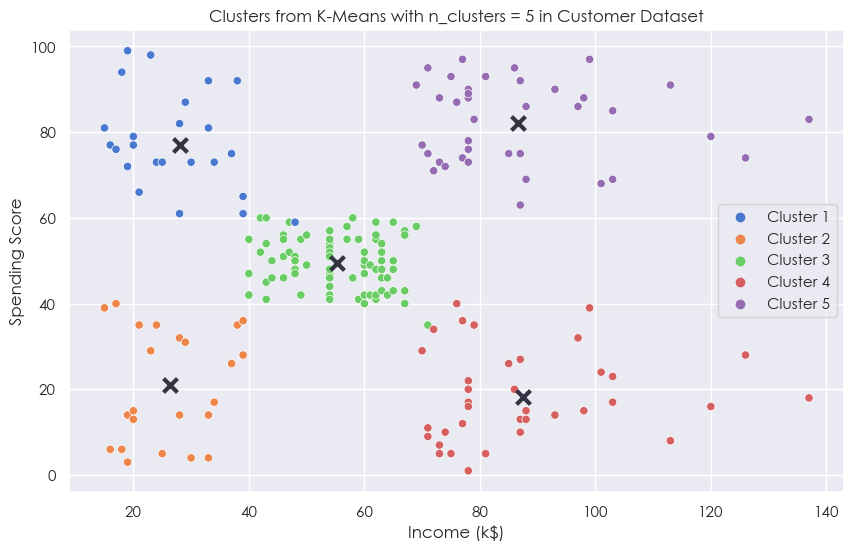

In [37]:
# Instantiate K-Means modelx
model = KMeans(n_clusters=5,n_init='auto',random_state=1)
# Fit the model
model.fit(customer_dummy)
# Get labels for each data point
labels = model.labels_
# Get cluster centers
cc = model.cluster_centers_
# Print silhouette score
evalResult(data=customer_dummy,label=labels,algName='Baseline K-Means Algorithm')
# Plot scatterplot for visual inspection
scatterPlot(x=customer_dummy['Income (k$)'],y=customer_dummy['Spending Score'],label=labels,algName='K-Means with n_clusters = 5',cc=cc)

**ANALYSIS OF BASELINE K-MEANS ALGORITHM:** 

We can see that the baseline k-means algorithm performs rather well with n_clusters = 5 as we can identify distinct clusters of customers. However, from the algorithm selection, we know that there is a better algorithm that outperform the K-Means Algorithm in terms of evaluation metrics, which was identified to be the MeanShift Clustering Algorithm.

### **BEST CLUSTERING ALGORITHM**


The best clustering algorithm identified was the **MeanShift Clustering Algorithm**. Since hyperparameter tuning was done earlier, we can move on to creating the final algorithm.

**FINAL ALGORITHM**

Evaluation Results:
-------------------------------------------------------------
Silhouette score for Meanshift Algorithm: 0.443
-------------------------------------------------------------


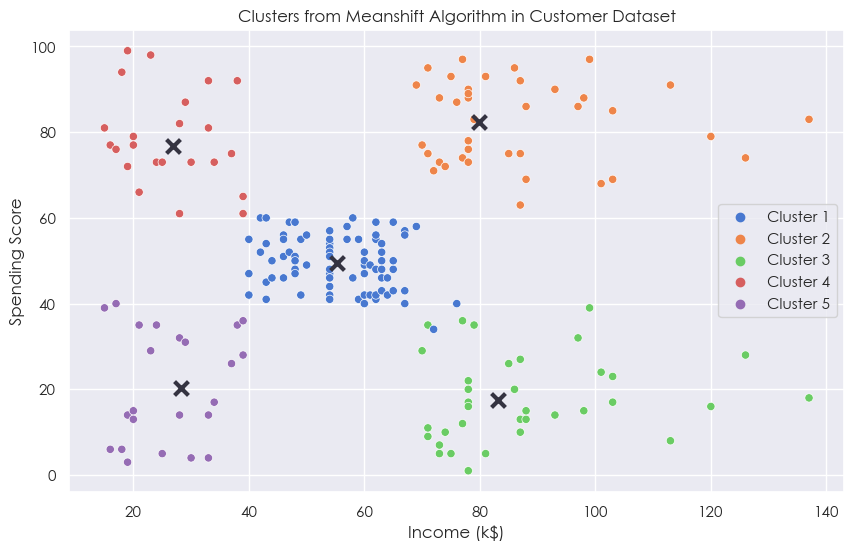

In [38]:
# Variable(s)
algName = 'Meanshift Algorithm'
# Obtain bandwidth hyperparameter value
bandwidth = estimate_bandwidth(customer_dummy,quantile=0.1)
# Instantiate and fit the model 
ms = MeanShift(bandwidth=bandwidth).fit(customer_dummy)  
# Get predicted labels
labels = ms.labels_
# Get cluster centers
cc = ms.cluster_centers_
# Print score metrics
evalResult(data=customer_dummy,label=labels,algName=algName)
# Plot scatterplot for visual inspection
scatterPlot(x=customer_dummy['Income (k$)'],y=customer_dummy['Spending Score'],label=labels,algName=algName,cc=cc)

<span style='font-size:26px;'>**ANALYSIS:**</span>

<span style='font-size:20px;'> **DISTINCT CLUSTERS | CLUSTER PROFILING:** 

[Describe the characteristics of each customer cluster]

**LOW** => Income range = 0k$ to 20k$, Spending Score range = 0 to 40

**AVERAGE** => Income range = 40k$ to 70k$, Spending Score range = 40 to 60

**HIGH** => Income range = 70k$ to 140k$, Spending Score range = 60 to 100

<p style='color:#4878d0'> Cluster 1 [BLUE] -> Customers who have <u>average</u> income and <u>average</u> spending

<p style='color:#ee854a'><b>Cluster 2 [ORANGE] -> Customers who have <u>high</u> income and <u>high</u> spending [MOST VALUABLE] </b>

<p style='color:#6acc64'>Cluster 3 [GREEN] -> Customers who have <u>high</u> income but <u>low</u> spending

<p style='color:#d65f5f'>Cluster 4 [RED] -> Customers who have <u>low</u> income but <u>high</u> spending

<p style='color:#956cb4'>Cluster 5 [PURPLE] -> Customers who have <u>low</u> income and <u>low</u> spending

<span style='font-size:20px;'> **OBSERVATIONS:**

In order for my mall to retain the most valuable customer cluster, it is identified that I should focus on appealing towards <span style='color:#ee854a'>cluster 2</span>, as this group of customers have high income and high spending, they have higher purchasing power all the time, and by ensuring that they continually have interest in shopping in the mall, it would drastically improve the mall's sales and profits as they would constantly have high spending, compared to a cluster such as <span style='color:#956cb4'>cluster 5</span>, which are customers who have low income and low spending, they are not a priority for the mall to retain as they do not much about much benefits to the mall in comparison. However, this does not mean the mall should neglect these customers, as even though some customer clusters may not financially benefit the mall, they can still bring about other benefits, such as improving the reputation and volume of customers in the mall, which are important aspects as well.

<span style='font-size:20px;'> **COMPARISON TO BASELINE K-MEANS ALGORITHM:**

Comparing this final model to the baseline k-means algorithm, there is not much difference between the two. However, my final model does have a slightly higher silhouette score.

<span style='font-size:26px;'>**FURTHER ANALYSIS ON CLUSTERS**

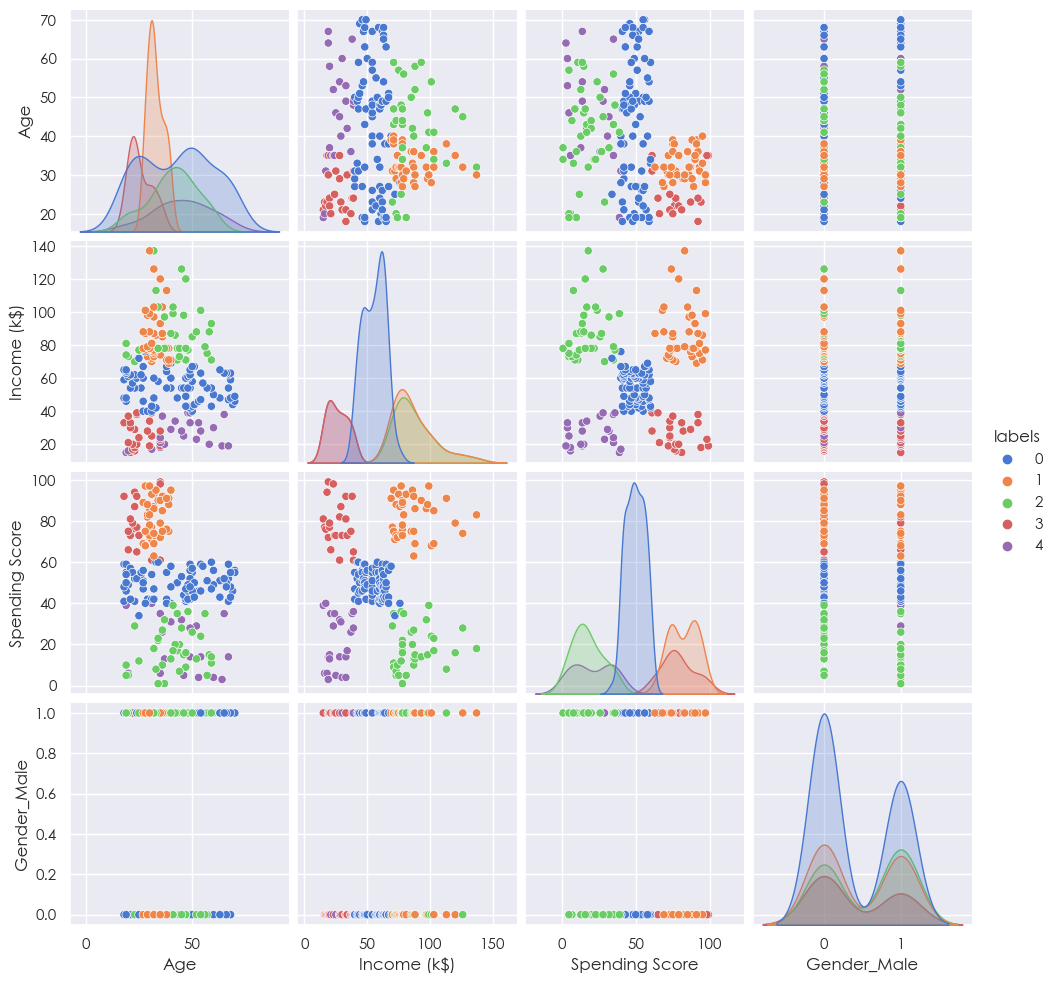

In [39]:
km = customer_dummy.copy()
km['labels'] = ms.labels_
sns.pairplot(km,hue='labels',palette=muted)
plt.show()

As you can see, it is possible to plot a pairplot to gather insights from each cluster, however, it is significantly difficult to analyse when they overlap, hence I produced more charts below for further analysis.

<span style='font-size:20px'>**CHART 1: COUNT OF CUSTOMERS IN EACH CLUSTER**</span>

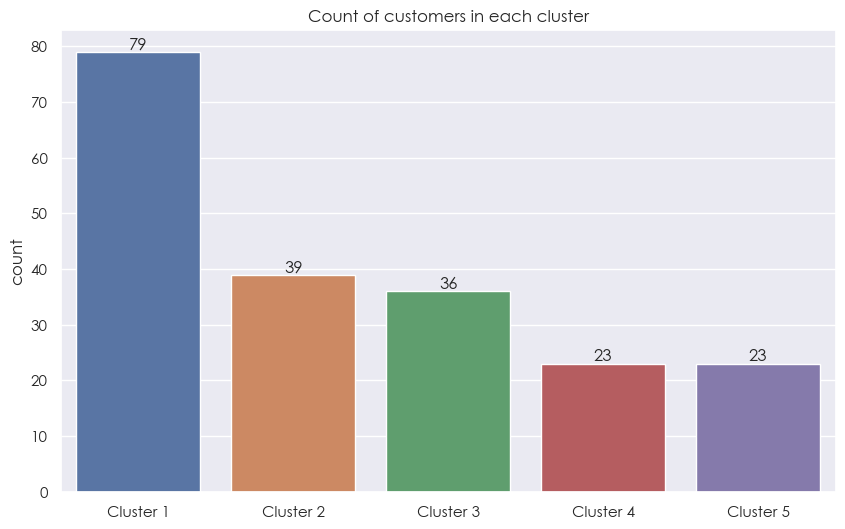

In [40]:
# Plotting countplot of customers in each cluster
fig,ax = plt.subplots(figsize=(10,6))
sns.countplot(x=labels).set(title='Count of customers in each cluster')
ax.set_xticklabels(['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5'])
ax.bar_label(ax.containers[0])
plt.show()

**ANALYSIS:** We can see that most customers tend to be part of <span style='color:#4878d0'> cluster 1</span>, followed by <span style='color:#ee854a'>cluster 2</span>, <span style='color:#6acc64'>cluster 3</span>, then <span style='color:#d65f5f'>cluster 4</span>, and lastly <span style='color:#956cb4'>cluster 5 </span>with the least amount of customers. This shows that most customers of my mall are of middle to high income and tend to spend a larger sum of money as well, which is beneficial to the mall, and the mall should focus on trying to increase the number of customers from <span style='color:#ee854a'>cluster 2</span>.

This also shows that aside from <span style='color:#ee854a'>cluster 2</span>, <span style='color:#4878d0'> cluster 1</span> is also of importance as most of the mall's customers are grouped in <span style='color:#4878d0'> cluster 1</span>, and hence I would also consider appealing to them.

<span style='font-size:20px'>**CHART 2: DISTRIBUTION OF AGE OF CUSTOMER BASED ON CLUSTER**</span>

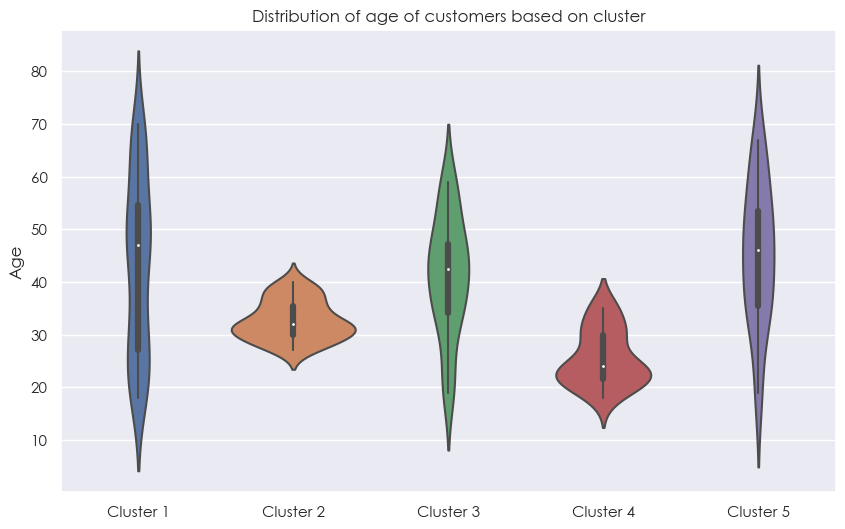

In [41]:
# Plotting violinplot of distribution of age of customers based on cluster
fig,ax = plt.subplots(figsize=(10,6))
sns.violinplot(data=customer_dummy,y='Age',x=labels,ax=ax).set(title='Distribution of age of customers based on cluster')
ax.set_xticklabels(['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5'])
plt.show()

**CHARACTERSTICS OF EACH CLUSTER:**

Format: *Cluster <u>Number</u> [COLOUR] -> Income & Spending Score Characteristics -> Age group*

<p style='color:#4878d0'> Cluster 1 [BLUE] -> Customers who have <u>average</u> income and <u>average</u> spending -> Tend to be in their forties to fifties, but has a larger age range from <10 to >80, hence spans all ages

<p style='color:#ee854a'><b>Cluster 2 [ORANGE] -> Customers who have <u>high</u> income and <u>high</u> spending -> Tend to be in their thirties [MOST VALUABLE]</b>

<p style='color:#6acc64'>Cluster 3 [GREEN] -> Customers who have <u>high</u> income but <u>low</u> spending -> Tend to be in their thirties to fifties

<p style='color:#d65f5f'>Cluster 4 [RED] -> Customers who have <u>low</u> income but <u>high</u> spending -> Tend to be in their twenties

<p style='color:#956cb4'>Cluster 5 [PURPLE] -> Customers who have <u>low</u> income and <u>low</u> spending -> Tend to be in their forties to fifties, but also has a larger age range from <10 to >80, hence spans all ages

**ANALYSIS:**

 We can see that the cluster of customers my mall should focus on, <span style='color:#ee854a'>cluster 2</span>, have customers who tend to be in their thirties, and hence I whould focus on products that appeal to this age group in order to retain the customers better.

<span style='color:#d65f5f'>Cluster 4</span>, which includes customers who have high spending as well, comprises of customers who are mostly in their twenties to thirties as well.

Thus, I would also focus on appealing towards the age groups of around 30 in order to retain these groups of customers and maximize profits.

<span style='font-size:20px'>**CHART 3: COUNT OF CUSTOMERS IN EACH CLUSTER SORTED BY GENDER**</span>

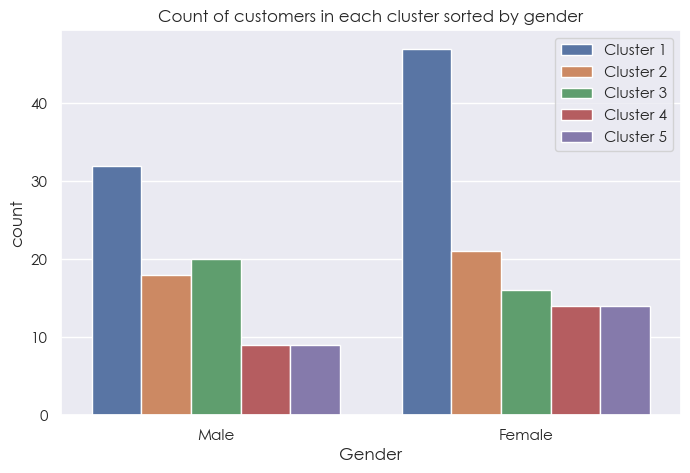

In [42]:
# Plotting countplot of customers in each cluster sorted by gender
fig,ax = plt.subplots(figsize=(8,5))
cluster_label = ["Cluster " + str(n+1) for n in labels]
sns.countplot(data=customer,x='Gender',hue=cluster_label,hue_order=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5'],ax=ax).set(title='Count of customers in each cluster sorted by gender')
plt.show()

**CHARACTERSTICS OF EACH CLUSTER:**

<p style='color:#4878d0'> Cluster 1 [BLUE] -> More females compared to males

<p style='color:#ee854a'><b>Cluster 2 [ORANGE] -> More females compared to males [MOST VALUABLE]</b>

<p style='color:#6acc64'>Cluster 3 [GREEN] -> More males compared to females

<p style='color:#d65f5f'>Cluster 4 [RED] -> More females compared to males

<p style='color:#956cb4'>Cluster 5 [PURPLE] -> More females compared to males

**ANALYSIS:** We can see that in the mall's most valuable cluster of customers, <span style='color:#ee854a'>cluster 2</span>, there are more female customers compared to male, hence more of their products should be catered towards females in order to appeal to them to continue shopping at the mall, garnering more sales for the mall.

Generally, we can see that in most clusters, there tend to be more females compared to males, which reinforces the fact that the mall should focus on appealing towards females to retain them.

## **7. CONCLUSION**

**How to perform customer segmentation using unsupervised machine learning algorithm in Python?**

In conlusion, customer segmentation was done with clustering algorithms such as KMeans, MeanShift or more, which are unsupervised machine learning algorithms shown through this report, enabling me to cluster the customers of my shopping mall to extract knowledge and information to improve the management of my shopping mall, learning who the most valuable customers are, and characteristics of customers in order to make more informed decisions in retaining them based on their profiles.

**Which group of customer is the most valuable to the shopping mall so that the shopping mall should do something to retain them?**

Hence, overall, in order for me to retain my mall's most valuable group of customers, I would appeal more towards:
 - Customers who have high income and high spending, which are customers from <span style='color:#ee854a'>cluster 2</span>
 - **Female** customers
 - Customers in their **thirties**

as this group of customers always have higher purchasing power from their high income and can help boost my mall's revenue, reputation, and overall is very beneficial for the mall to retain them.

Appealing to them can be done in multitudes of ways, such as focusing on advertising or increasing stock of popular female products such as skincare, clothings, and accessories or having more luxury brands and premium stores, or even loyalty programmes for this group of customers, all of which would aid my mall in retaining this group of customers to want to continue shopping at the mall.

However, the mall should ensure to not neglect other groups of customers as even though they may not bring about financial benefits, they can still bring about other benefits that are essential to the mall, such as increased reputation.

In conclusion, my mall should create a more luxurious and exclusive shopping environment to appeal to my most valuable group of customers, which were customers who have high income and high spending at the mall [<span style='color:#ee854a'>Cluster 2</span>], whilst also ensuring that other groups of customer's needs are not neglected by the mall in order to have significantly increased benefits. My mall should also do research in order to understand the customer's needs, desires and lifestyle choices to tailor the mall's attraction towards them specifically, in order to retain their most valuable group of customers and reap its benefits of doing so.

**Takeaways:**

From this assignment, I have also learnt a lot as I was also able to apply what I have learnt from my AIML lessons into practice in clustering. I felt that I faced less difficulties when doing clustering compared to time series, but I still did face difficulties nonetheless, such as in deciding the flow of the system I was making, whether I should perform hypertuning before/after selection and such. 

<p style='text-align:center; font-size:30px;'><b>-END-</p>